In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# These two lines set nicer looking defaults for matplotlib
import seaborn as sns
sns.set(style='ticks', palette='Set2')

# Gives a nice progress bar
from tqdm import trange

# The Bak-Sneppen model

A simple model for evolution, introduced by Per Bak and Kim Sneppen in 1993:
https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.71.4083


## The model:

* Make a vector of length $N$, representing different species, each with a randomly assigned "fitness" between 0 and 1.
* At each timestep, do the following:
 * Select the species with the lowest fitness.
 * Give that species, and its left and right neighbours, a new random fitness between 0 and 1 (using periodic boundary conditions).


## The idea:

The idea of the model is not to be a true, accurate model for evalution, but to represent the feature that when one species changes, then this affects other nearby species, because they now have to compete with the newly evolved species.

In [2]:
def run_model(N, T):
    # The Bak-Sneppen model.
    # See Per Bak and Kim Sneppen, Physical review letters 71.24 (1993): 4083.
    # https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.71.4083

    # Arrays to hold age (time since evolving) and fitness
    age = np.zeros((T, N ))
    fitness = np.zeros((T, N))

    # Initialise with random fitness
    fitness[0,:] = np.random.random(N)

    # Keep track of the index where mutation happens
    mutation = np.zeros(T)

    for t in trange(1, T):
        # Copy previous time's data
        fitness[t,:] = fitness[t-1,:]
        age[t,:] = age[t-1,:] + 1    

        # Find index of least fit species
        i = np.argmin(fitness[t,:])
        # Store that index
        mutation[t] = i

        # Set that species to random, and update age
        fitness[t, i]   = np.random.random()
        age[t, i]   = 0
        # Set the left neighbour to random, and update age
        fitness[t, i-1] = np.random.random()
        age[t, i-1] = 0
        # Set the right neighbour to random, and update age
        # using division modulo (% operator) N to map index N to 0
        fitness[t, (i+1) % N] = np.random.random()
        age[t, (i+1) % N] = 0

    return fitness, age, mutation


def run_model_reduced(N, T):
    # The Bak-Sneppen model.
    # See Per Bak and Kim Sneppen, Physical review letters 71.24 (1993): 4083.
    # https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.71.4083
    
    # This version does not store all of history, to reduce memory use

    # Initialise with random fitness
    fitness = np.random.random(N)

    # Keep track of the index where mutation happens
    mutation = np.zeros(T)

    for t in trange(1, T):
        # Find index of least fit species
        i = np.argmin(fitness)
        # Store that index
        mutation[t] = i

        # Set that species to random
        fitness[i] = np.random.random()
        # Set the left neighbour to random
        fitness[i-1] = np.random.random()
        # Set the right neighbour to random
        # using division modulo (% operator) N to map index N to 0
        fitness[(i+1) % N] = np.random.random()

    return fitness, mutation

## First, a small run to make a plot of the "fitness landscape" directly

In [3]:
N = 500 # Number of species
T = 20000 # Number of timesteps
fitness, age, mutation = run_model(N, T)

100%|██████████| 19999/19999 [00:00<00:00, 67882.52it/s]


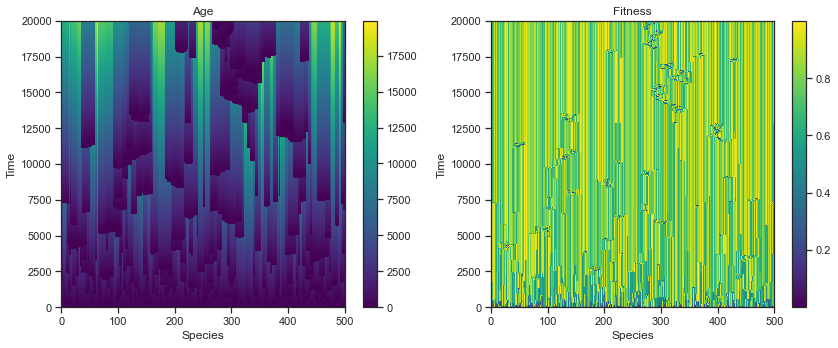

In [4]:
# Make a figure with two subplots, side by side
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

# Plot age per species (x-axis), as a function of time (y-axis)
mesh = axes[0].pcolorfast(age, cmap = 'viridis')
plt.colorbar(mesh, ax = axes[0])
axes[0].set_ylabel('Time')
axes[0].set_xlabel('Species')
axes[0].set_title('Age')

# Plot fitness per species (x-axis), as a function of time (y-axis)
mesh = axes[1].pcolorfast(fitness, cmap = 'viridis')
plt.colorbar(mesh, ax = axes[1])
axes[1].set_ylabel('Time')
axes[1].set_xlabel('Species')
axes[1].set_title('Fitness')

plt.tight_layout()

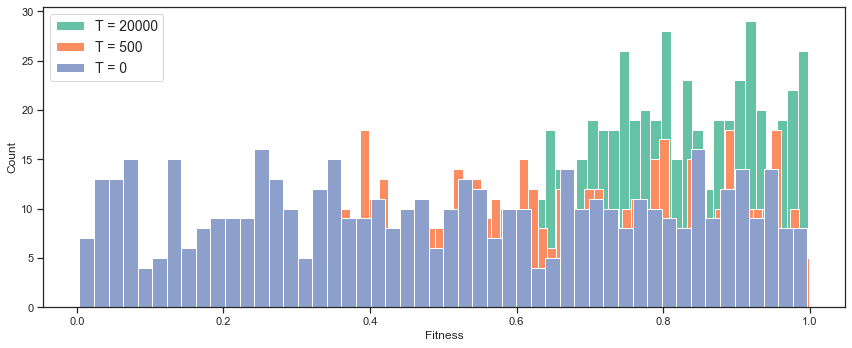

In [5]:
# Plot distribution of fitness at different times
fig = plt.figure(figsize = (12, 5))

plt.hist(fitness[-1,:], bins = 50, label = f'T = {T}')
plt.hist(fitness[500,:], bins = 50, label = 'T = 500')
plt.hist(fitness[0,:], bins = 50, label = f'T = 0')

plt.legend(fontsize = 14)
plt.xlabel('Fitness')
plt.ylabel('Count')
plt.tight_layout()

## Do a longer run, without storing the full matrices

In [6]:
N = 2000 # Number of species
T = 10000000 # Number of timesteps
fitness, mutation = run_model_reduced(N, T)

100%|██████████| 9999999/9999999 [00:52<00:00, 190848.84it/s]


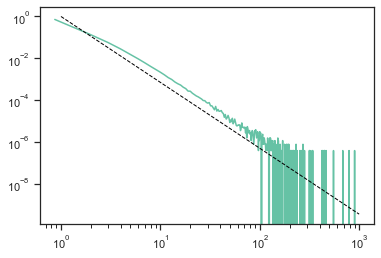

In [7]:
# Find distance between mutation, taking periodic BC into account
dist = mutation[1:] - mutation[:-1]
dist = np.minimum(dist, N-abs(dist))

# Cut away the first part of the simulation,
# before "equilibrium" is reached.
cutoff = 3000000

# Create and plot histogram
hist, bins = np.histogram(dist[cutoff:], bins = np.arange(0.5, 1000.5, 1), density = True)
# Logarithmically spaced midponts, for plotting
mids = np.sqrt(bins[:-1]*bins[1:])
plt.plot(mids, hist)

# Plot scaling law found in paper:
x = np.logspace(0,3,100)
plt.plot(x, x**-3.15, '--', c = 'k', lw = 1)

# Logscale
plt.xscale('log')
plt.yscale('log')

# The Lorenz attractor

In [8]:
from numba import njit
from scipy.integrate import odeint
from mpl_toolkits import mplot3d
# This magic command gives interactive plots
%matplotlib notebook

In [9]:
# Just-in-time compiling these two functions
# seems to gain about a factor 2 in speed.
# (Note that the first time the function is called,
# it is slower, since compilation takes place.)
# (Note also that you should never define and use
# a just-in-time compiled function in the same cell
# in a notebook, as it will be compiled every time)

@njit
def lorenz(x, sigma, rho, beta):
    # The Lorenz system (see Ch. 9 in Strogatz)
    xdot = sigma*(x[1] - x[0])
    ydot = x[0]*(rho - x[2]) - x[1]
    zdot = x[0]*x[1] - beta*x[2]
    return np.array([xdot, ydot, zdot])

@njit
def f(x, t):
    # Wrapper function for the lorenz equations
    sigma = 10.0
    rho   = 28.0
    beta  = 8/3
    return lorenz(x, sigma, rho, beta)

In [10]:
x0 = [  5.62590715,  21.47606796,  26.79759756]

T  = np.linspace(0, 100, 10000)

# Integrating ODE with function from scipy
# (which is a thin wrapper for LSODA, written in fortran)
tol = 1e-12
X   = odeint(f, x0, T, atol = tol, rtol = tol)

<IPython.core.display.Javascript object>


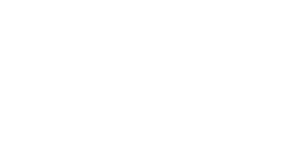

In [11]:
fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection='3d')
ax.plot(*X.T)

# Diffusion-limited aggregation

In [12]:
%matplotlib inline

In [13]:
def run_simulation():
    N  = 1000 # Number of particles
    R  = 0.007 # Radius
    D  = 0.1 # Diffusivity
    dt = 0.0005 # Timestep
    Tmax = 1 # Time to run simulation

    # Array to keep track of not-yet-stuck particles (true or false)
    free = np.ones(N, dtype = np.bool)
    # Array for particle positions
    X = np.random.random((2, N))

    # Initialise one particle at center, and freeze it
    X[:,0] = [0.5, 0.5]
    free[0] = False

    # Time loop
    Nt = int(Tmax / dt)
    for t in trange(Nt):
        # Increment time
        t += dt
        # Move particles randomly
        # Indexing with boolean array
        X[:,free] += np.sqrt(2*D)*np.random.normal(loc = 0, scale = np.sqrt(dt), size = (2, sum(free)))
        # Apply periodic boundary conditions
        X = X%1
        # Freeze any particles that touch any frozen particles
        for i in range(N):
            if not free[i]:
                # Calculate distance from stuck particle, to all other particles
                dists = np.sqrt(np.sum((X - X[:,i][:,None])**2, axis = 0))
                # Set all particles closer than 2R to stuck
                free[dists <= 2*R] = False
    return X, free

In [14]:
X, free = run_simulation()

100%|██████████| 2000/2000 [00:19<00:00, 104.73it/s]


NameError: name 'R' is not defined

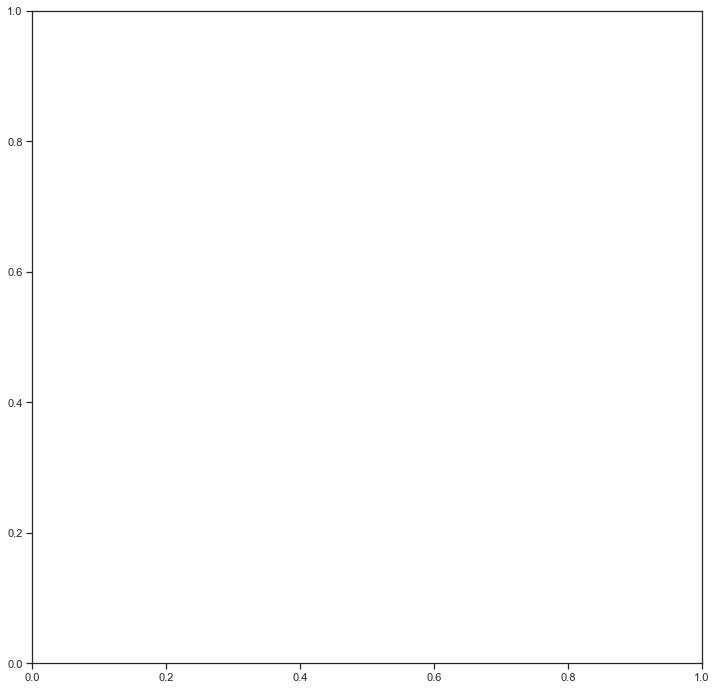

In [15]:
fig, ax = plt.subplots(figsize = (12, 12))
for i in range(N):
    ax.add_artist(plt.Circle((X[0,i], X[1,i]), R, linewidth=0))